In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
import random

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/dbm829/.conda/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/dbm829/projects/interpreting_omics_models/02_experiments/notebooks
/home/dbm829/projects/interpreting_omics_models


In [2]:
# set a random seed

seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
data = ad.read_h5ad('./01_data/human_bonemarrow.h5ad')

In [73]:
# load model from the saved checkpoint
# models are automaticallt saved after training

model = multiDGD.DGD.load(data=data, save_dir='./03_results/models/', model_name='human_bonemarrow_l20_h2-3_test50e')

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [5]:
reps = model.representation.z.detach()

### utils

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Sparse Autoencoder Model with Mechanistic Interpretability
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            #nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Mechanistic Loss Function for Sparsity and Interpretability
def loss_function(reconstructed, original, encoded, weights, sparsity_penalty, l1_weight):
    # Reconstruction loss (MSE)
    mse_loss = nn.MSELoss()(reconstructed, original)
    
    # L1 regularization for encoded activations (promotes sparsity in the hidden layer)
    l1_loss = l1_weight * torch.mean(torch.abs(encoded))

    # Weight sparsity (to promote interpretable features in the weights)
    weight_sparsity_loss = sparsity_penalty * torch.sum(torch.abs(weights))

    # Combined loss
    total_loss = mse_loss + l1_loss + weight_sparsity_loss
    return total_loss

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_obs_activations(obs, activations, unique_ids):
    obs_vals = np.unique(data.obs[obs].values)

    means = np.zeros((len(obs_vals), len(unique_ids)))

    for i, ct in enumerate(obs_vals):
        ids_ct = np.where(data.obs[obs] == ct)[0]
        activations_ct = activations[ids_ct,:].detach().cpu().numpy()
        avg_activations = np.mean(activations_ct, axis=0)
        means[i, :] = avg_activations[unique_ids]
        del activations_ct
        del avg_activations

    df_means = pd.DataFrame(means, index=obs_vals, columns=unique_ids)

    sns.heatmap(df_means, cmap='rocket_r')
    plt.title(f'Mean activations: {obs}')
    plt.xlabel('Hidden unit')
    plt.ylabel(obs)
    plt.show()

def plot_activation_range(data, activations, range_start_end=None, indices=None, obs=None, plot_size=(10,10), obs_order=None):

    if range_start_end is not None:
        activs = activations[:, range_start_end[0]:range_start_end[1]].detach().cpu().numpy()
    elif indices is not None:
        activs = activations[:, indices].detach().cpu().numpy()
    else:
        activs = activations.detach().cpu().numpy()

    if obs is not None:
        # sort by obs
        if range_start_end is not None:
            df_temp = pd.DataFrame(activs, columns=range(range_start_end[0], range_start_end[1]))
        elif indices is not None:
            df_temp = pd.DataFrame(activs, columns=indices)
        else:
            df_temp = pd.DataFrame(activs, columns=range(activs.shape[1]))
        df_temp['obs'] = data.obs[obs].values
        df_temp.index = data.obs[obs].values
        if obs_order is not None:
            df_temp['obs'] = pd.Categorical(df_temp['obs'], categories=obs_order, ordered=True)
        df_temp = df_temp.sort_values(by='obs')

        fig, ax = plt.subplots(figsize=plot_size)
        sns.heatmap(df_temp.drop(columns='obs'), cmap='rocket_r')
        if range_start_end is not None:
            plt.title(f'Activations for range {range_start_end[0]}-{range_start_end[1]}')
        else:
            plt.title(f'Activations')
        plt.xlabel('Hidden unit')
        plt.ylabel(obs)
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=plot_size)
        sns.heatmap(activs, cmap='rocket_r')
        if range_start_end is not None:
            plt.title(f'Activations for range {range_start_end[0]}-{range_start_end[1]}')
        else:
            plt.title(f'Activations')
        plt.xlabel('Hidden unit')
        plt.show()

import torch

# Function to get the unique indices of active hidden units across all samples
def get_unique_active_unit_indices(model, data_loader, threshold=1e-5):
    unique_active_indices = set()  # Use a set to store unique active neuron indices

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data in data_loader:
            inputs = data
            
            # Forward pass through the encoder to get the hidden layer activations
            _, encoded = model(inputs)
            
            # Find the indices of the active neurons (where activation > threshold)
            active_indices_batch = (encoded > threshold).nonzero(as_tuple=False)  # Get nonzero indices

            # This returns indices in the form [batch_idx, neuron_idx]
            # We are only interested in neuron_idx for overall unique active units
            unique_active_indices.update(active_indices_batch[:, 1].tolist())

    # Convert to sorted list for convenience
    unique_active_indices = sorted(unique_active_indices)

    return unique_active_indices

# Assuming 'model' is your trained SparseAutoencoder and 'data_loader' is your dataset loader
def count_active_hidden_units(model, data_loader, threshold=1e-5):
    total_active_units = 0
    total_samples = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for data in data_loader:
            inputs = data
            
            # Forward pass through the encoder to get the hidden layer activations
            _, encoded = model(inputs)
            
            # Count how many activations are above the threshold (active neurons)
            active_units_per_sample = (encoded > threshold).sum(dim=1)
            
            # Sum over all samples
            total_active_units += active_units_per_sample.sum().item()
            total_samples += inputs.size(0)

    # Calculate the average number of active units per sample
    avg_active_units = total_active_units / total_samples
    return avg_active_units

from scipy.signal import find_peaks

def detect_valleys(activations, individual_activation):
    # Compute histogram (adjust bins as necessary)
    hist_values, bin_edges = np.histogram(activations[:, individual_activation].detach().cpu().numpy(), bins=100)
    
    # Get bin centers (midpoints of bin edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Invert the histogram to find valleys (local minima)
    inverted_hist = -hist_values

    # Find peaks in the inverted histogram (which correspond to valleys in the original histogram)
    valley_indices, _ = find_peaks(inverted_hist, distance=5)  # Adjust distance based on expected group separations

    # Get the bin center values corresponding to the valleys
    valley_positions = bin_centers[valley_indices]

    return valley_positions

### training

Epoch [1/500], Loss: 0.00018662
Epoch [2/500], Loss: 0.00006149
Epoch [3/500], Loss: 0.00005988
Epoch [4/500], Loss: 0.00005916
Epoch [5/500], Loss: 0.00005872
Epoch [6/500], Loss: 0.00005808
Epoch [7/500], Loss: 0.00005743
Epoch [8/500], Loss: 0.00005675
Epoch [9/500], Loss: 0.00005592
Epoch [10/500], Loss: 0.00005519
Epoch [11/500], Loss: 0.00005429
Epoch [12/500], Loss: 0.00005348
Epoch [13/500], Loss: 0.00005272
Epoch [14/500], Loss: 0.00005180
Epoch [15/500], Loss: 0.00005098
Epoch [16/500], Loss: 0.00005028
Epoch [17/500], Loss: 0.00004933
Epoch [18/500], Loss: 0.00004857
Epoch [19/500], Loss: 0.00004772
Epoch [20/500], Loss: 0.00004685
Epoch [21/500], Loss: 0.00004607
Epoch [22/500], Loss: 0.00004530
Epoch [23/500], Loss: 0.00004416
Epoch [24/500], Loss: 0.00004359
Epoch [25/500], Loss: 0.00004256
Epoch [26/500], Loss: 0.00004180
Epoch [27/500], Loss: 0.00004100
Epoch [28/500], Loss: 0.00004006
Epoch [29/500], Loss: 0.00003915
Epoch [30/500], Loss: 0.00003839
Epoch [31/500], Los

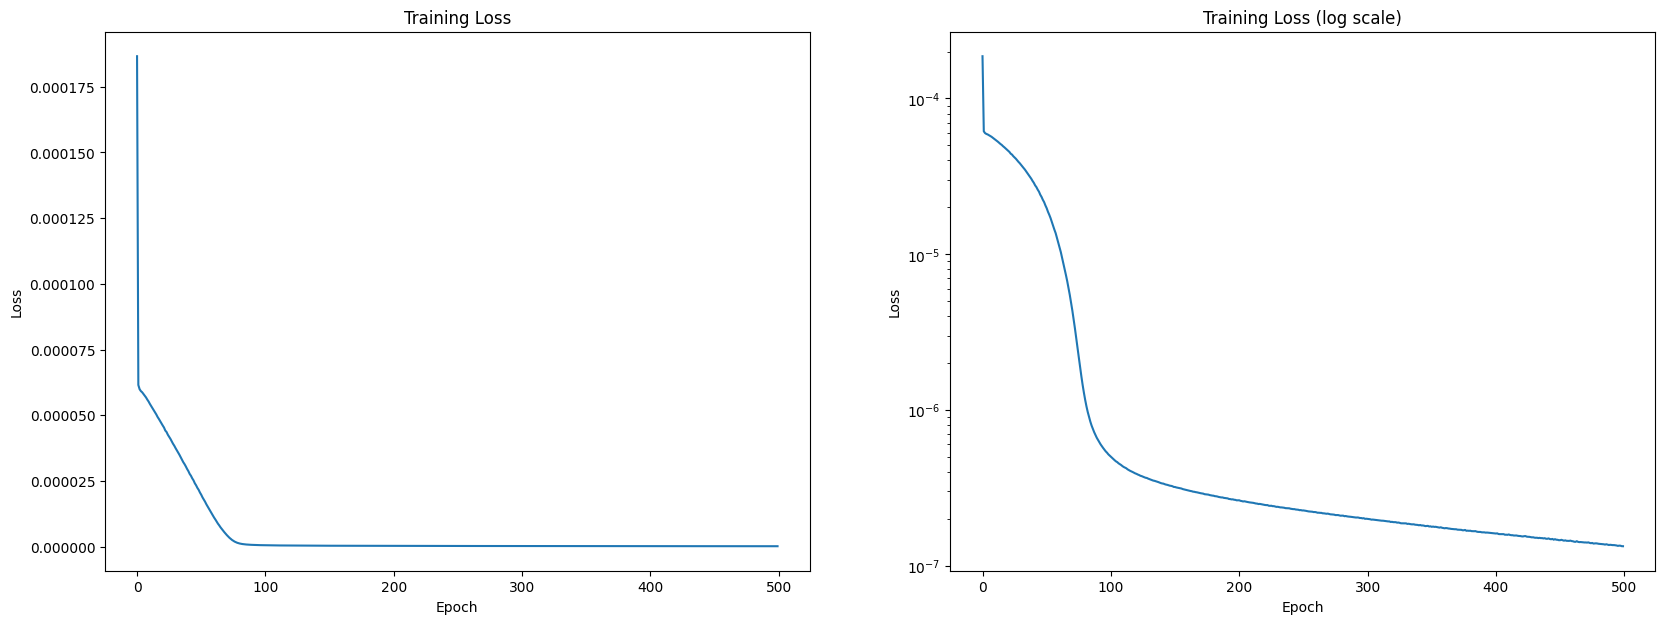

In [9]:
# Hyperparameters
input_size = reps.shape[1]  # Number of input neurons
hidden_size = 10**4
learning_rate = 1e-4
num_epochs = 500
batch_size = 128
sparsity_penalty = 0  # Weight for weight sparsity
l1_weight = 1e-3  # Weight for activation sparsity
#early_stopping = 10

# Load dataset (Replace with your own dataset)
# Example using random data, replace with actual dataset
train_data = reps.clone()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize model
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model = sae_model.to(device)

# Optimizer
optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):

    # early stopping if the last 10 epochs have not improved the loss
    #if len(losses) > early_stopping:
    #    if np.min(losses[-early_stopping:]) == losses[-early_stopping]:
    #        print(f'Early stopping at epoch {epoch + 1}')
    #        break
    
    total_loss = 0
    for x in train_loader:
        # Get inputs and convert to torch Variable
        inputs = x
        inputs = inputs.to(device)
        
        # Forward pass
        outputs, encoded = sae_model(inputs)
        
        # Compute loss
        loss = loss_function(
            outputs, 
            inputs, 
            encoded, 
            sae_model.encoder[0].weight,  # Pass the encoder's weights for weight sparsity
            sparsity_penalty, 
            l1_weight
        )
        
        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    losses.append(total_loss / len(train_loader))
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.8f}')

print("Training complete.")

# plot loss curve (normal) and log_scaled
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs[0].plot(losses)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')
axs[1].plot(losses)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss (log scale)')
axs[1].set_yscale('log')
plt.show()

In [10]:
# save the model
sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'
torch.save(sae_model.state_dict(), sae_model_save_name+'.pt')

In [18]:
# load the model
sae_model_save_name = '03_results/models/sae_model_10000_l1-1e-3_lr-1e-4_500epochs'

input_size = reps.shape[1]
hidden_size = 10**4
sae_model = SparseAutoencoder(input_size, hidden_size)
sae_model.load_state_dict(torch.load(sae_model_save_name+'.pt'))
sae_model.to(device)

batch_size = 128
train_data = reps.clone()
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

### plot latents and avtivations over cell types

In [29]:
threshold = 1e-10

unique_active_unit_indices = get_unique_active_unit_indices(sae_model, train_loader, threshold=threshold)
print(f'Unique Active Neuron Indices: {unique_active_unit_indices}')
print(f'Number of unique active hidden units: {len(unique_active_unit_indices)}')

avg_active_hidden_units = count_active_hidden_units(sae_model, train_loader, threshold=threshold)
print(f'Average number of active hidden units per sample: {avg_active_hidden_units:.2f}')

Unique Active Neuron Indices: [2, 4, 5, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 30, 31, 32, 34, 36, 37, 38, 43, 45, 47, 48, 49, 50, 51, 54, 56, 59, 61, 64, 66, 67, 70, 71, 73, 75, 77, 80, 81, 82, 84, 85, 86, 87, 88, 89, 93, 94, 95, 97, 98, 99, 100, 101, 104, 106, 107, 109, 112, 114, 115, 117, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 137, 139, 140, 143, 144, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 165, 168, 172, 173, 174, 175, 178, 181, 182, 184, 188, 189, 190, 191, 192, 196, 198, 199, 201, 202, 204, 205, 206, 208, 209, 211, 212, 213, 214, 218, 220, 221, 222, 223, 224, 225, 227, 229, 237, 239, 240, 243, 246, 247, 249, 250, 251, 252, 254, 256, 261, 262, 263, 264, 265, 266, 268, 271, 272, 273, 274, 275, 278, 279, 281, 283, 284, 286, 289, 290, 291, 293, 298, 299, 302, 304, 306, 307, 309, 310, 312, 313, 314, 315, 316, 317, 320, 322, 324, 325, 326, 328, 330, 331, 335, 336, 337, 343, 346, 347, 348, 349, 350, 351, 352, 353, 355, 356, 3

/tmp/ipykernel_484192/661681877.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))


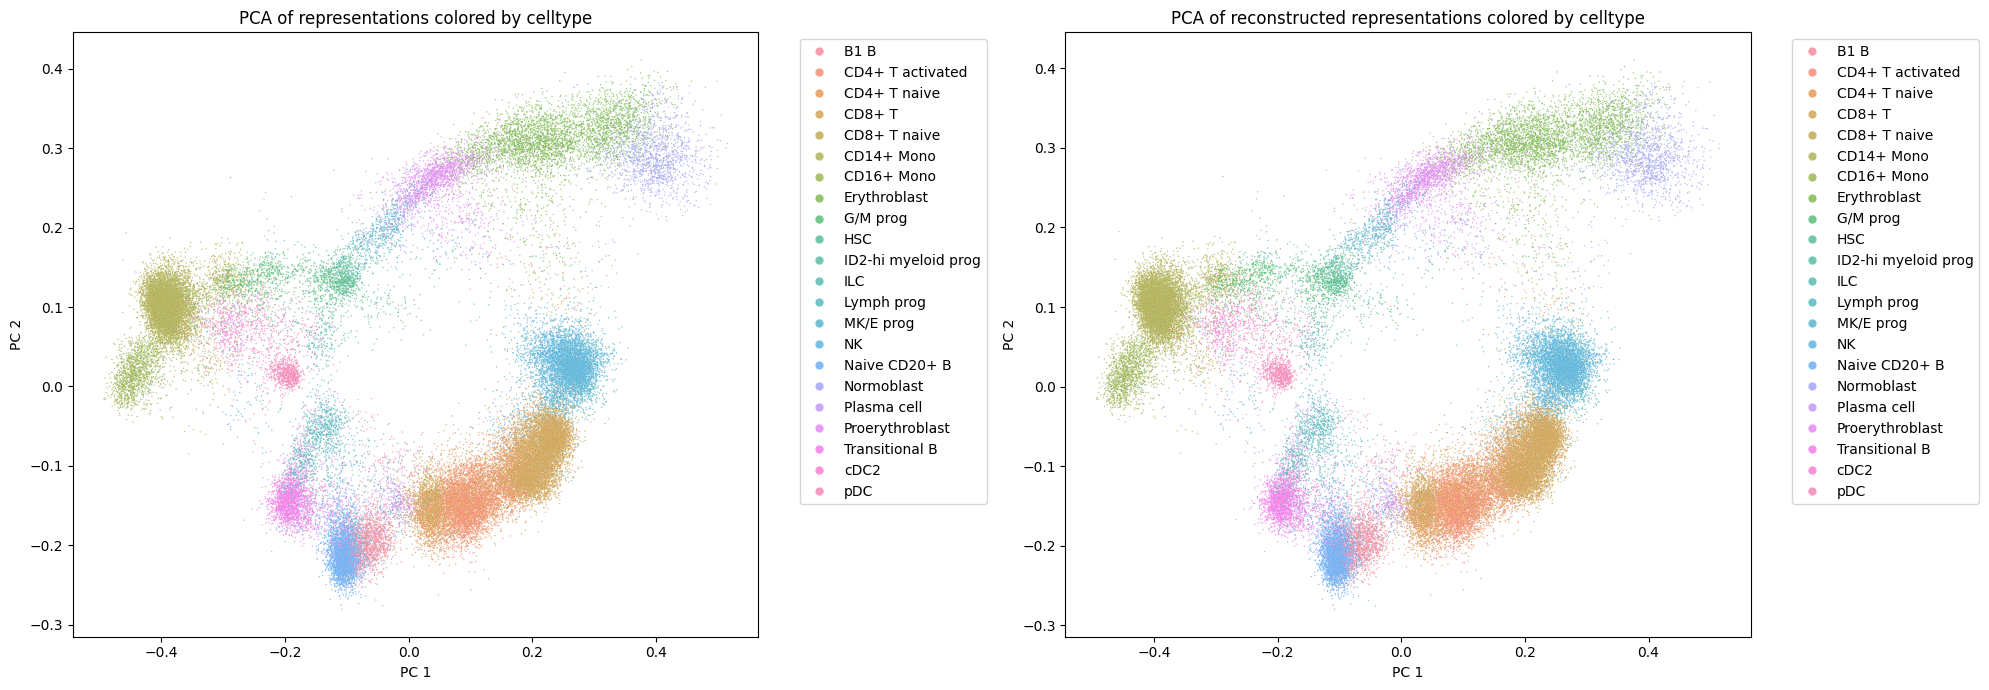

In [12]:
# create a pca of the reps
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(reps.cpu().numpy())
# plot the representations
reps_transformed = pca.transform(reps.cpu().numpy())

reps_reconstructed, activations = sae_model(torch.tensor(reps, dtype=torch.float32).to(device))
reps_reconstructed = reps_reconstructed.detach().cpu().numpy()
reps_reconstructed_transformed = pca.transform(reps_reconstructed)

# plot the pca
data = data[data.obs["train_val_test"] == "train"]

df_celltypes = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
df_celltypes['type'] = 'original'
df_celltypes['celltype'] = data.obs['cell_type'].values
df_temp = pd.DataFrame(reps_reconstructed_transformed, columns=['PC 1', 'PC 2'])
df_temp['type'] = 'reconstructed'
df_temp['celltype'] = data.obs['cell_type'].values
#df_celltypes = pd.concat([df_celltypes, df_temp])

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.scatterplot(data=df_celltypes, x='PC 1', y='PC 2', hue='celltype', ax=axs[0], s=1, alpha=0.7)
axs[0].set_title('PCA of representations colored by celltype')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=6)

sns.scatterplot(data=df_temp, x='PC 1', y='PC 2', hue='celltype', ax=axs[1], s=1, alpha=0.7)
axs[1].set_title('PCA of reconstructed representations colored by celltype')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=6)

plt.tight_layout()
plt.show()

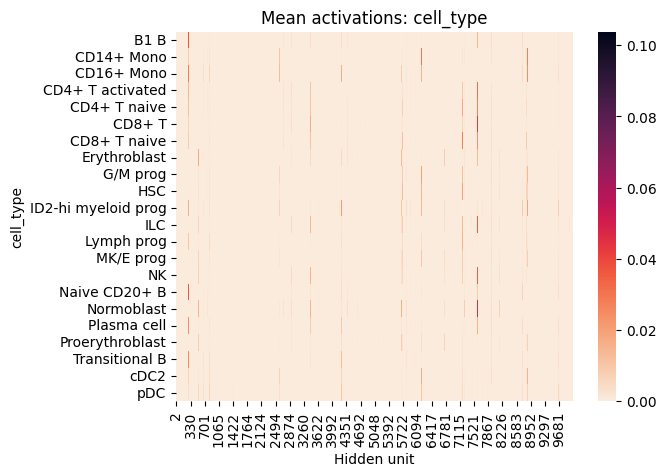

In [13]:
plot_obs_activations('cell_type', activations, unique_active_unit_indices)

In [ ]:
# loop through all cell types and make heatmap plots of their activations

# get the cell types
celltypes = np.unique(data.obs['cell_type'].values)

for ct in celltypes:
    ids_ct = data.obs['cell_type'] == ct
    activations_ct = activations[ids_ct].detach().cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(20, 2))
    sns.heatmap(activations_ct, cmap='rocket_r', ax=ax)
    plt.title(f'Activations for cell type {ct}')
    plt.xlabel('Hidden unit')
    plt.ylabel('Cell')
    plt.show()

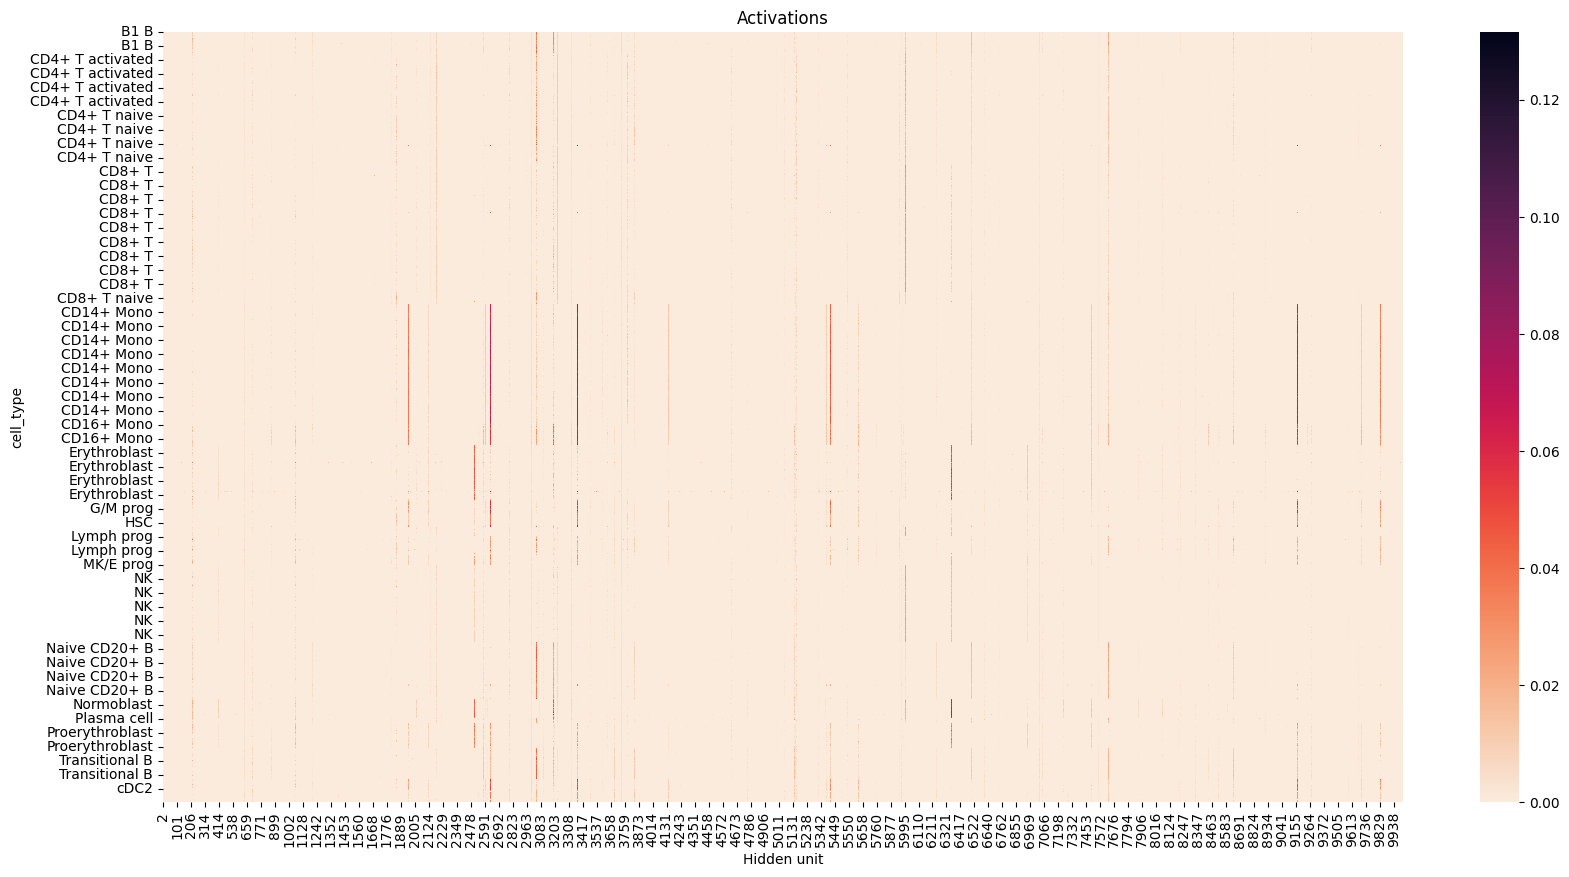

In [32]:
plot_activation_range(data, activations, indices=unique_active_unit_indices, obs='cell_type', plot_size=(20,10))

### Hematopoietic cell differentiation

Can I find features that increase from HSC to normoblast and is absent in other cell types?

In [51]:
hematopoiesis_features = unique_active_unit_indices.copy()

# conditions for features to be met

# 1. the average value of the feature must be higher in the hematopoietic cells than in the non-hematopoietic cells
celltypes = np.unique(data.obs['cell_type'].values)
hematopoietic_cells = ['MK/E prog', 'Proerythroblast', 'Erythroblast', 'Normoblast']
stem_cells = ['HSC']
non_hematopoietic_cells = [x for x in celltypes if x not in hematopoietic_cells + stem_cells]
temp_indices_true = np.where(data.obs['cell_type'].isin(hematopoietic_cells))[0]
temp_indices_false = np.where(data.obs['cell_type'].isin(non_hematopoietic_cells))[0]
avg_activations_true = np.mean(activations[temp_indices_true,:].detach().cpu().numpy(), axis=0)
avg_activations_false = np.mean(activations[temp_indices_false,:].detach().cpu().numpy(), axis=0)
condition_accepted = avg_activations_true > avg_activations_false
print(f'Condition 1: {np.sum(condition_accepted)} features meet the condition')
hematopoiesis_features = np.intersect1d(hematopoiesis_features, np.where(condition_accepted)[0])

# 2. the average value of the feature must be higher in the hematopoietic cells than in the stem cells
temp_indices_false = np.where(data.obs['cell_type'].isin(stem_cells))[0]
avg_activations_false = np.mean(activations[temp_indices_false,:].detach().cpu().numpy(), axis=0)
condition_accepted = avg_activations_true > avg_activations_false
print(f'Condition 2: {np.sum(condition_accepted)} features meet the condition')
hematopoiesis_features = np.intersect1d(hematopoiesis_features, np.where(condition_accepted)[0])
print(f'Number of hematopoiesis features: {len(hematopoiesis_features)}')
temp_indices_true, temp_indices_false, avg_activations_true, avg_activations_false = None, None, None, None

# 3. the average value must increase consistently from the stem cells to the hematopoietic cells
ct_1 = 'HSC'
for ct_2 in hematopoietic_cells:
    temp_indices_low = np.where(data.obs['cell_type'] == ct_1)[0]
    temp_indices_high = np.where(data.obs['cell_type'] == ct_2)[0]
    avg_activations_low = np.mean(activations[temp_indices_low,:].detach().cpu().numpy(), axis=0)
    avg_activations_high = np.mean(activations[temp_indices_high,:].detach().cpu().numpy(), axis=0)
    condition_accepted = avg_activations_low < avg_activations_high
    hematopoiesis_features = np.intersect1d(hematopoiesis_features, np.where(condition_accepted)[0])
    ct_1 = ct_2
print(f'Condition 3: Number of hematopoiesis features: {len(hematopoiesis_features)}')

Condition 1: 3043 features meet the condition
Condition 2: 3140 features meet the condition
Number of hematopoiesis features: 2661
Condition 3: Number of hematopoiesis features: 44


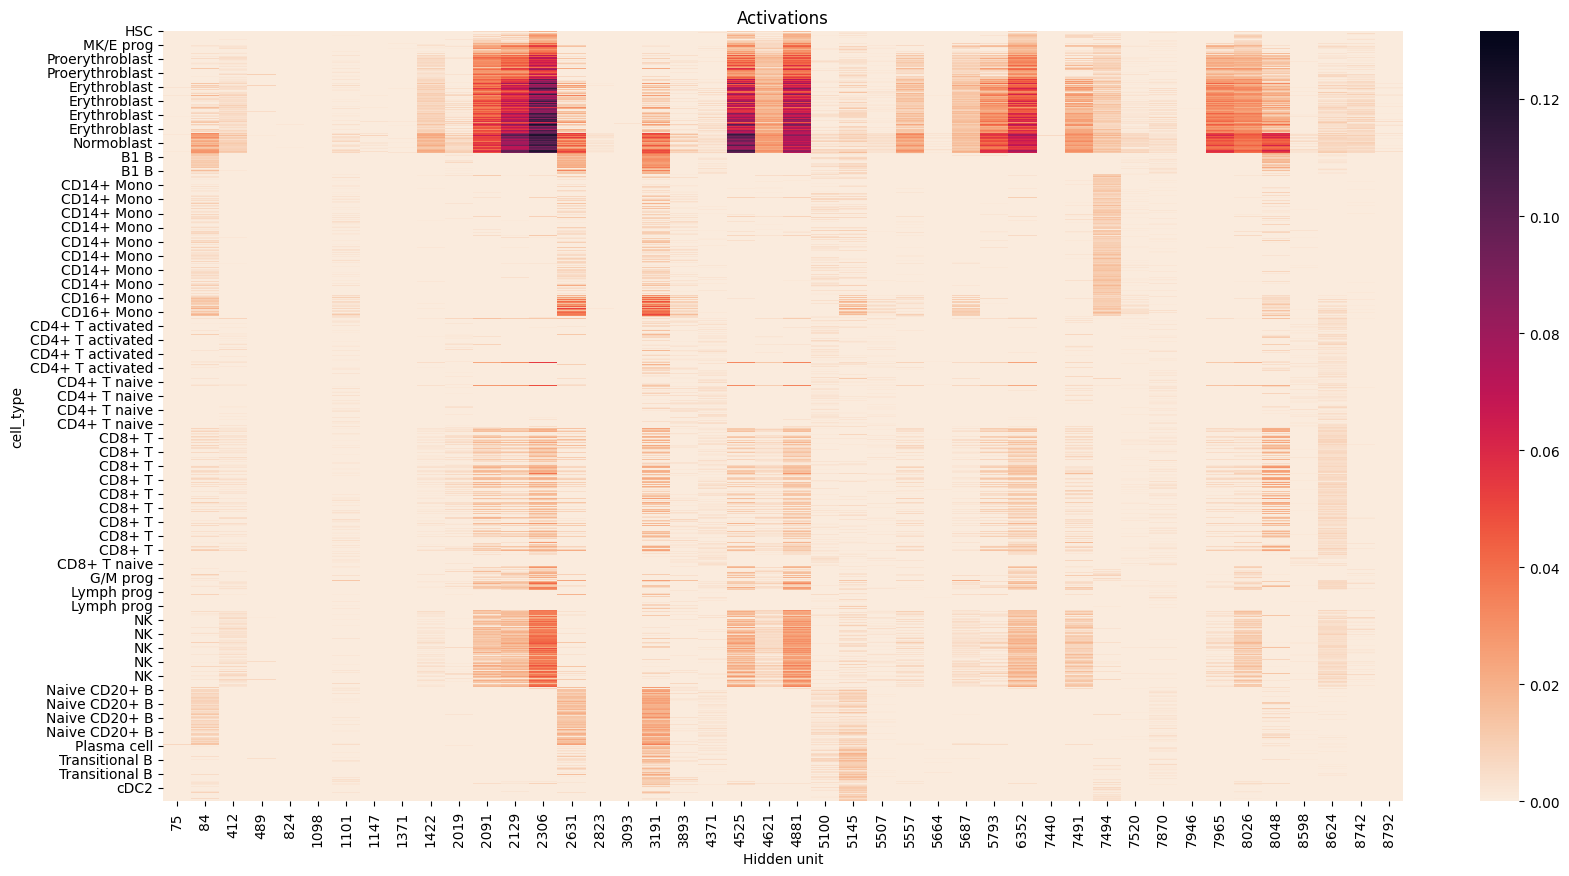

In [54]:
plot_activation_range(
    data,
    activations,
    indices=hematopoiesis_features,
    obs='cell_type',
    plot_size=(20,10),
    obs_order=stem_cells + hematopoietic_cells + non_hematopoietic_cells
)

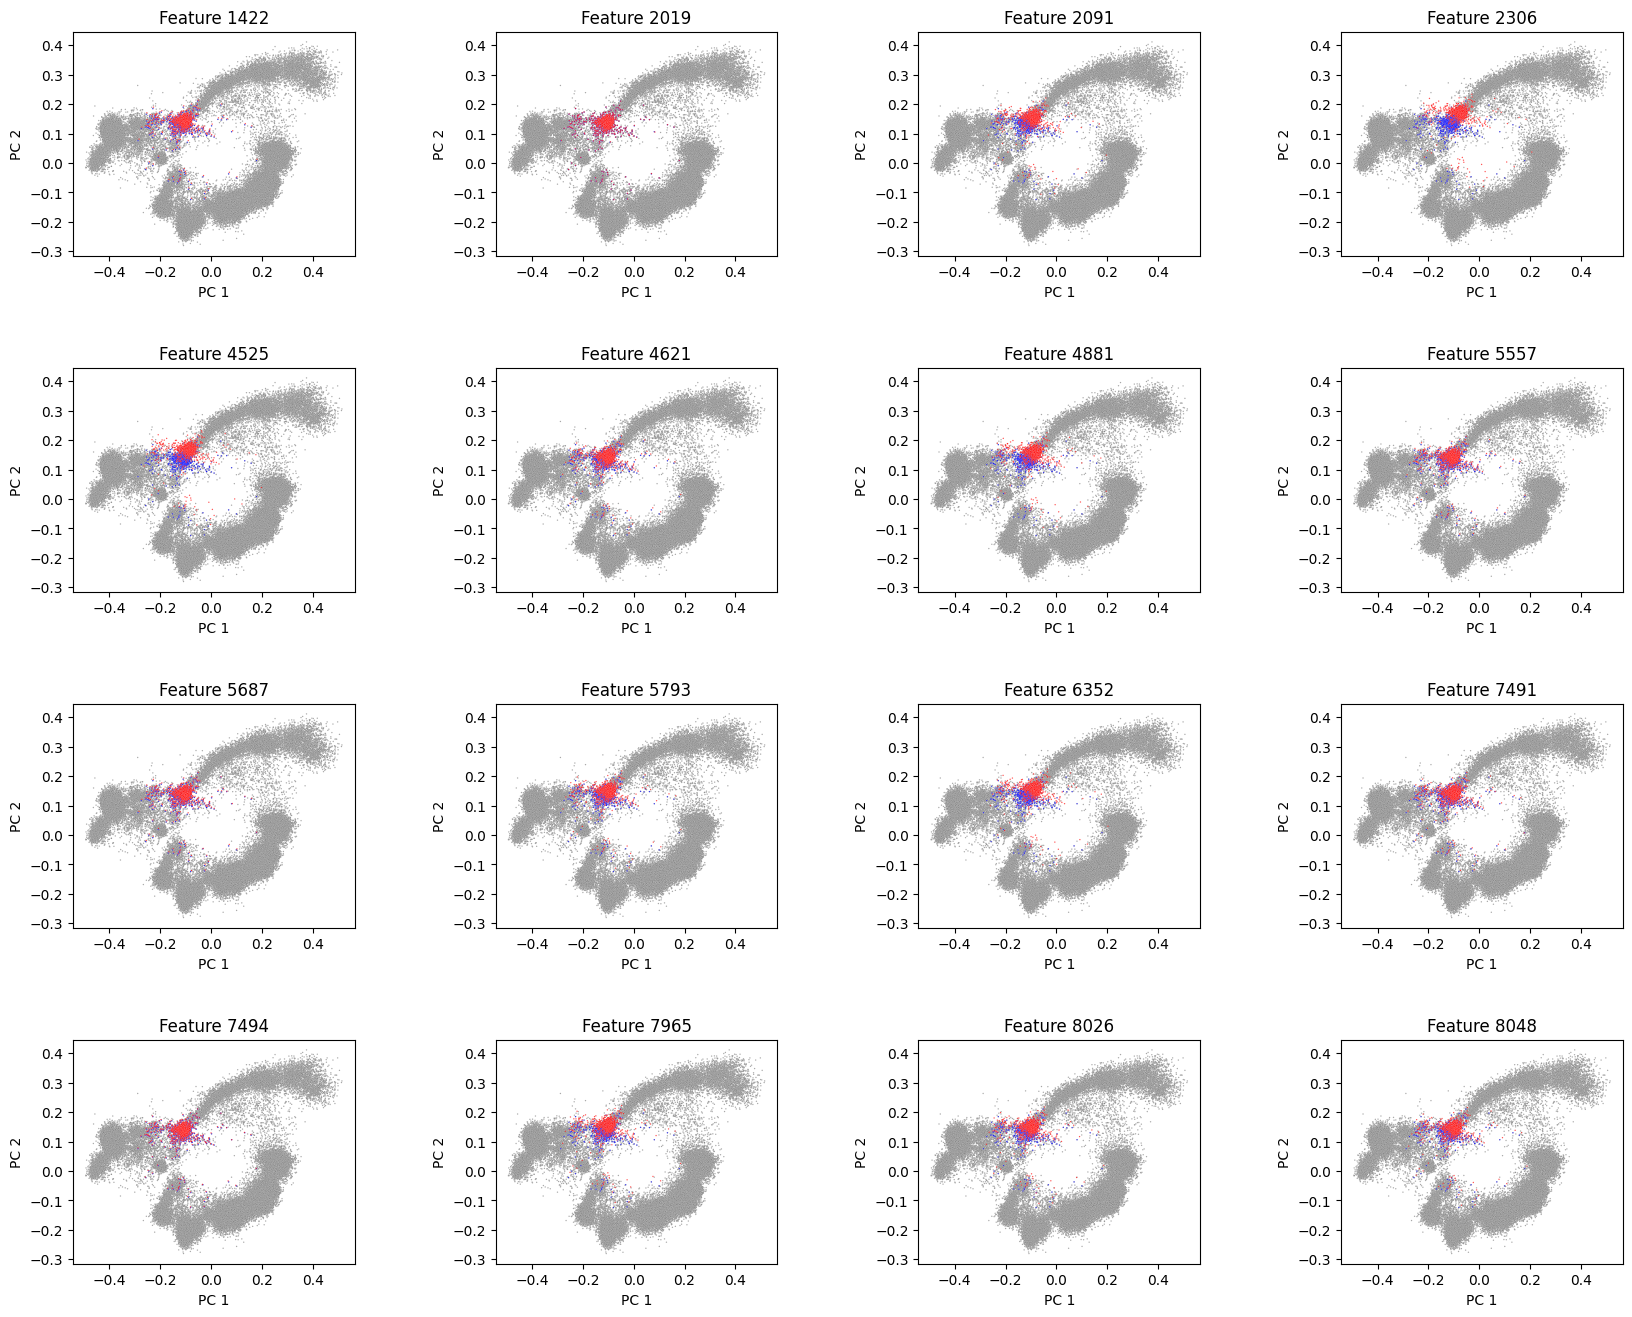

In [63]:
stricter_selection = [1422, 2019, 2091, 2306, 4525, 4621, 4881, 5557, 5687, 5793, 6352, 7491, 7494, 7965, 8026, 8048]

hsc_indices = np.where(data.obs['cell_type'] == 'HSC')[0]
latents_non_hsc = reps[np.where(data.obs['cell_type'] != 'HSC')[0], :].cpu().numpy()
latents_hsc = reps[hsc_indices, :].cpu().numpy()
activs_hsc = activations[hsc_indices, :]
active_values_normoblast = torch.Tensor(np.mean(activations[np.where(data.obs['cell_type'] == 'Normoblast')[0],:].detach().cpu().numpy(), axis=0)).to(device)

# for each feature, get the HSC samples and plot the predicted latents before and after perturbation

# make a figure with 4 columns and as many rows as needed for the features

if len(stricter_selection) % 4 == 0:
    n_rows = len(stricter_selection) // 4
else:
    n_rows = len(stricter_selection) // 4 + 1

fig, axs = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

i = 0
for feat in stricter_selection:
    activs_perturbed = activs_hsc.clone()
    activs_perturbed[:, feat] = active_values_normoblast[feat]
    latents_perturbed = sae_model.decoder(activs_perturbed.to(device)).detach().cpu().numpy()

    df_temp = pd.DataFrame(reps_transformed, columns=['PC 1', 'PC 2'])
    df_temp['type'] = 'other'
    df_temp2 = pd.DataFrame(pca.transform(latents_hsc), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC'
    df_temp = pd.concat([df_temp, df_temp2])
    df_temp2 = pd.DataFrame(pca.transform(latents_perturbed), columns=['PC 1', 'PC 2'])
    df_temp2['type'] = 'HSC perturbed'
    df_temp = pd.concat([df_temp, df_temp2])

    col, row = i % 4, i // 4
    sns.scatterplot(df_temp, x='PC 1', y='PC 2', hue='type', ax=axs[row, col], s=1, alpha=0.7, palette=['grey', 'blue', 'red'])
    axs[row, col].get_legend().remove()
    axs[row, col].set_title(f'Feature {feat}')
    i = i + 1

plt.show()